### Table of Contents

- [skip to training the small purchase model](#Small-Train)
- [skip to training the large purchase model](#Large-Train)
- [XGBoost with standard dataset](#XGBoost-Model-standard-dataset)
- [XGBoost with summary dataset](#XGBoost-Model-summary-dataset)
- [Model Evaluation](#Model-Evaluation)

In [1]:
import pandas as pd
import numpy as np


#visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('bmh')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

#machine learning libraries
import xgboost as xgb
import catboost as cb 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from matplotlib import patheffects


import os


#project modules
import src.wrangle as wr
import src.summaries as su
import src.explore as ex


pd.set_option('display.float_format', lambda x: '%.5f' % x)
from importlib import reload

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [ ]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

## time series at a glance

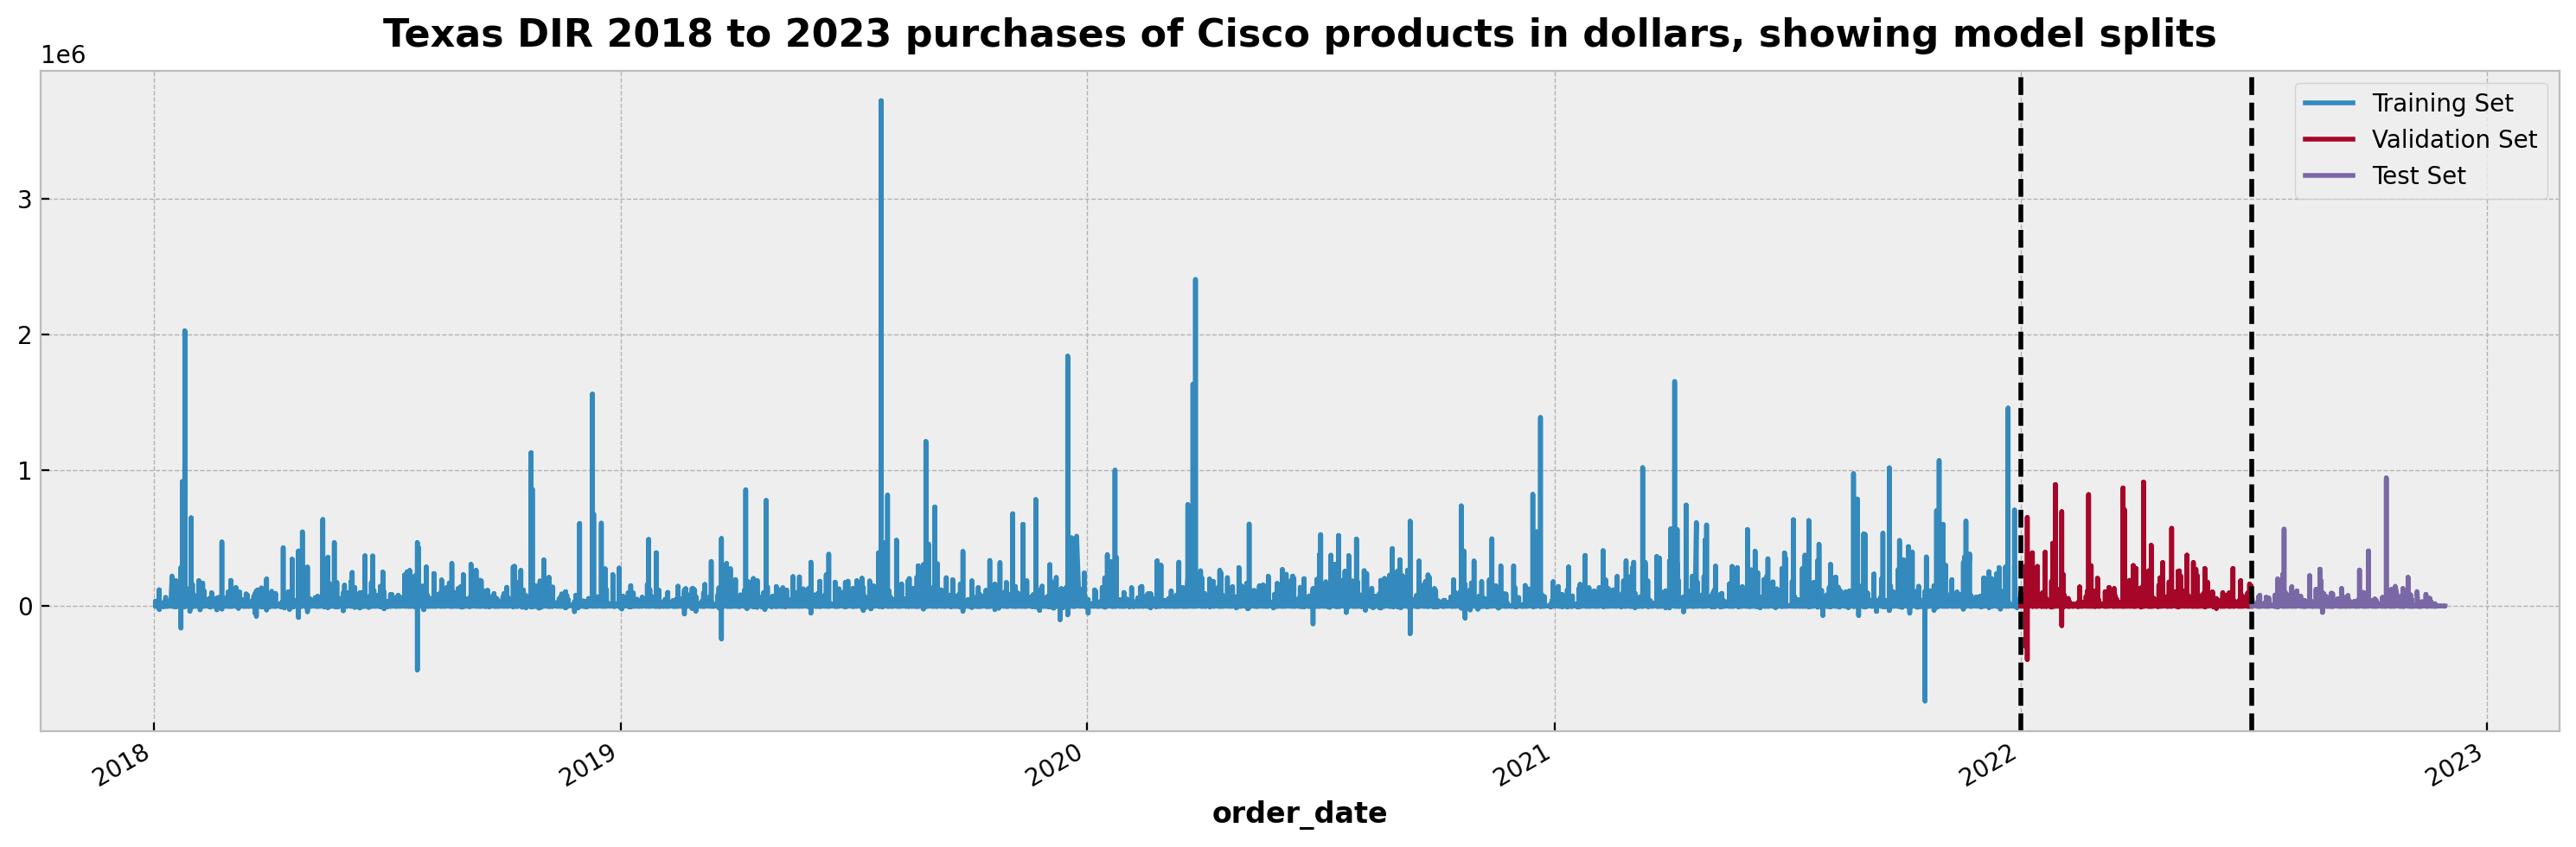

In [19]:
fix, ax = plt.subplots(figsize = (15,5))
train['purchase_amount'].plot(ax = ax, label='Training Set', title='Texas DIR 2018 to 2023 purchases of Cisco products in dollars, showing model splits')
validate['purchase_amount'].plot(ax = ax, label='Validation Set')
test['purchase_amount'].plot(ax = ax, label='Test Set')
ax.axvline('01-01-22', color='black', ls='--')
ax.axvline('07-01-22', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
plt.show()

In [22]:
df.columns

Index(['customer_name', 'customer_type', 'customer_city', 'reseller_name',
       'reseller_city', 'customer_zip', 'order_quantity', 'unit_price',
       'po_number', 'shipped_date', 'order_date_copy', 'year', 'quarter',
       'month_name', 'day_name', 'month', 'week', 'day_of_week', 'day_of_year',
       'purchase_amount'],
      dtype='object')

<AxesSubplot:xlabel='month_name', ylabel='purchase_amount'>

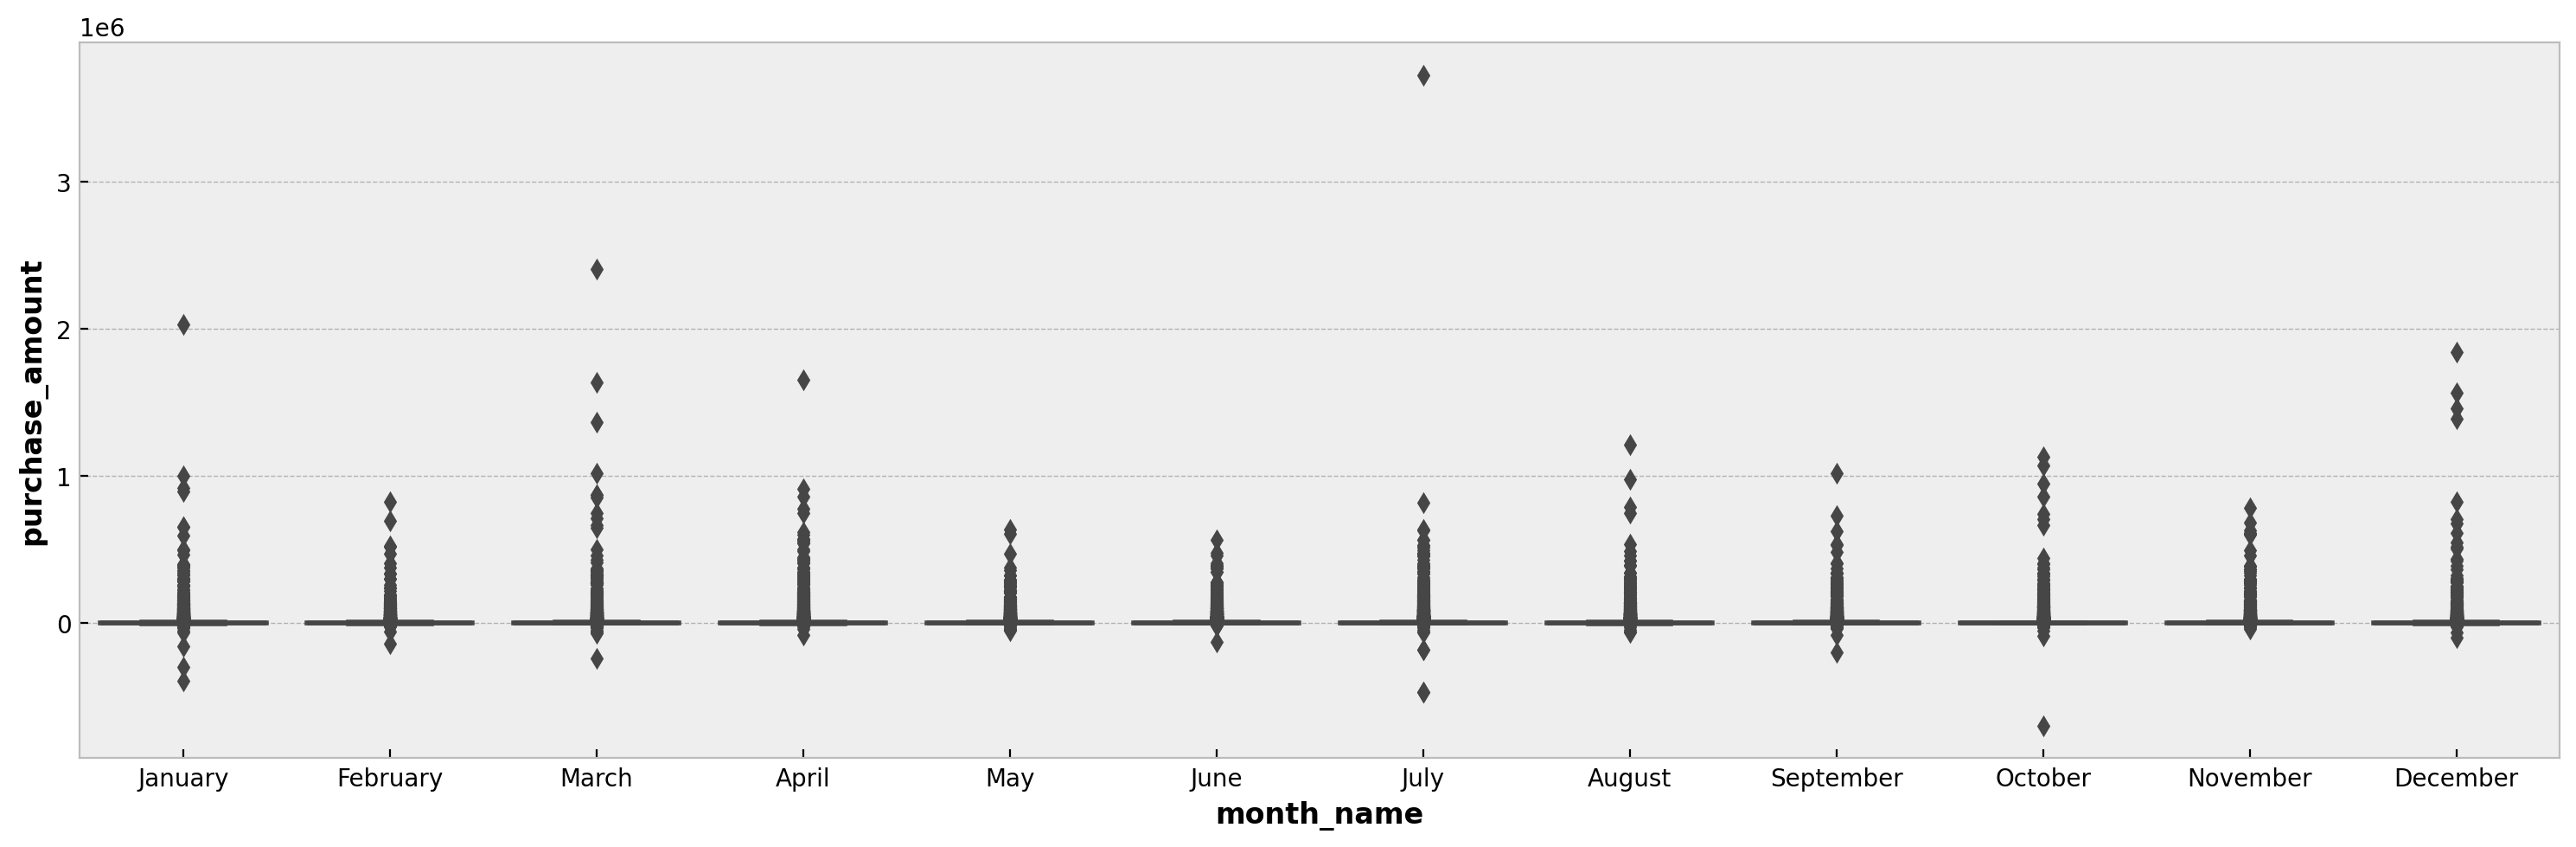

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x = 'month_name', y = 'purchase_amount')

<AxesSubplot:xlabel='year', ylabel='purchase_amount'>

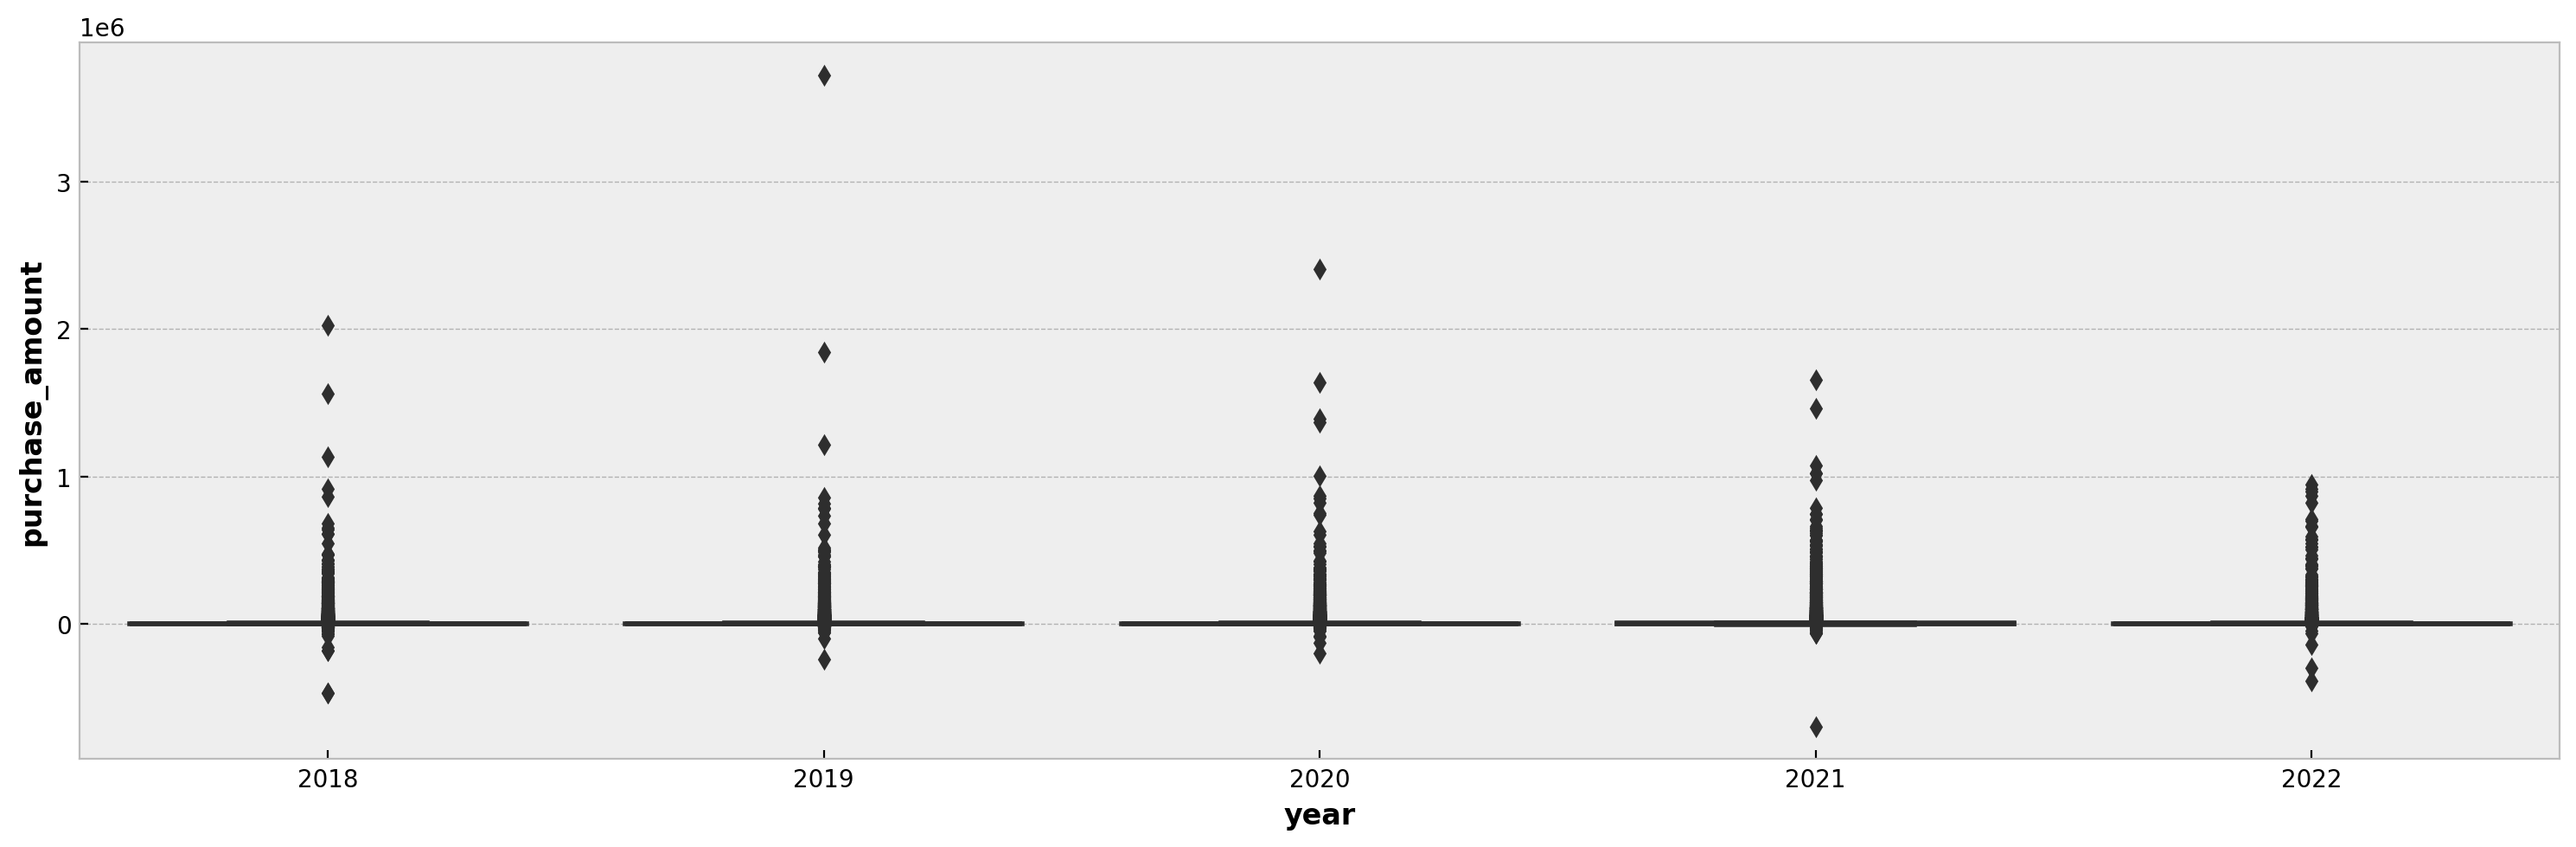

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x = 'year', y = 'purchase_amount')

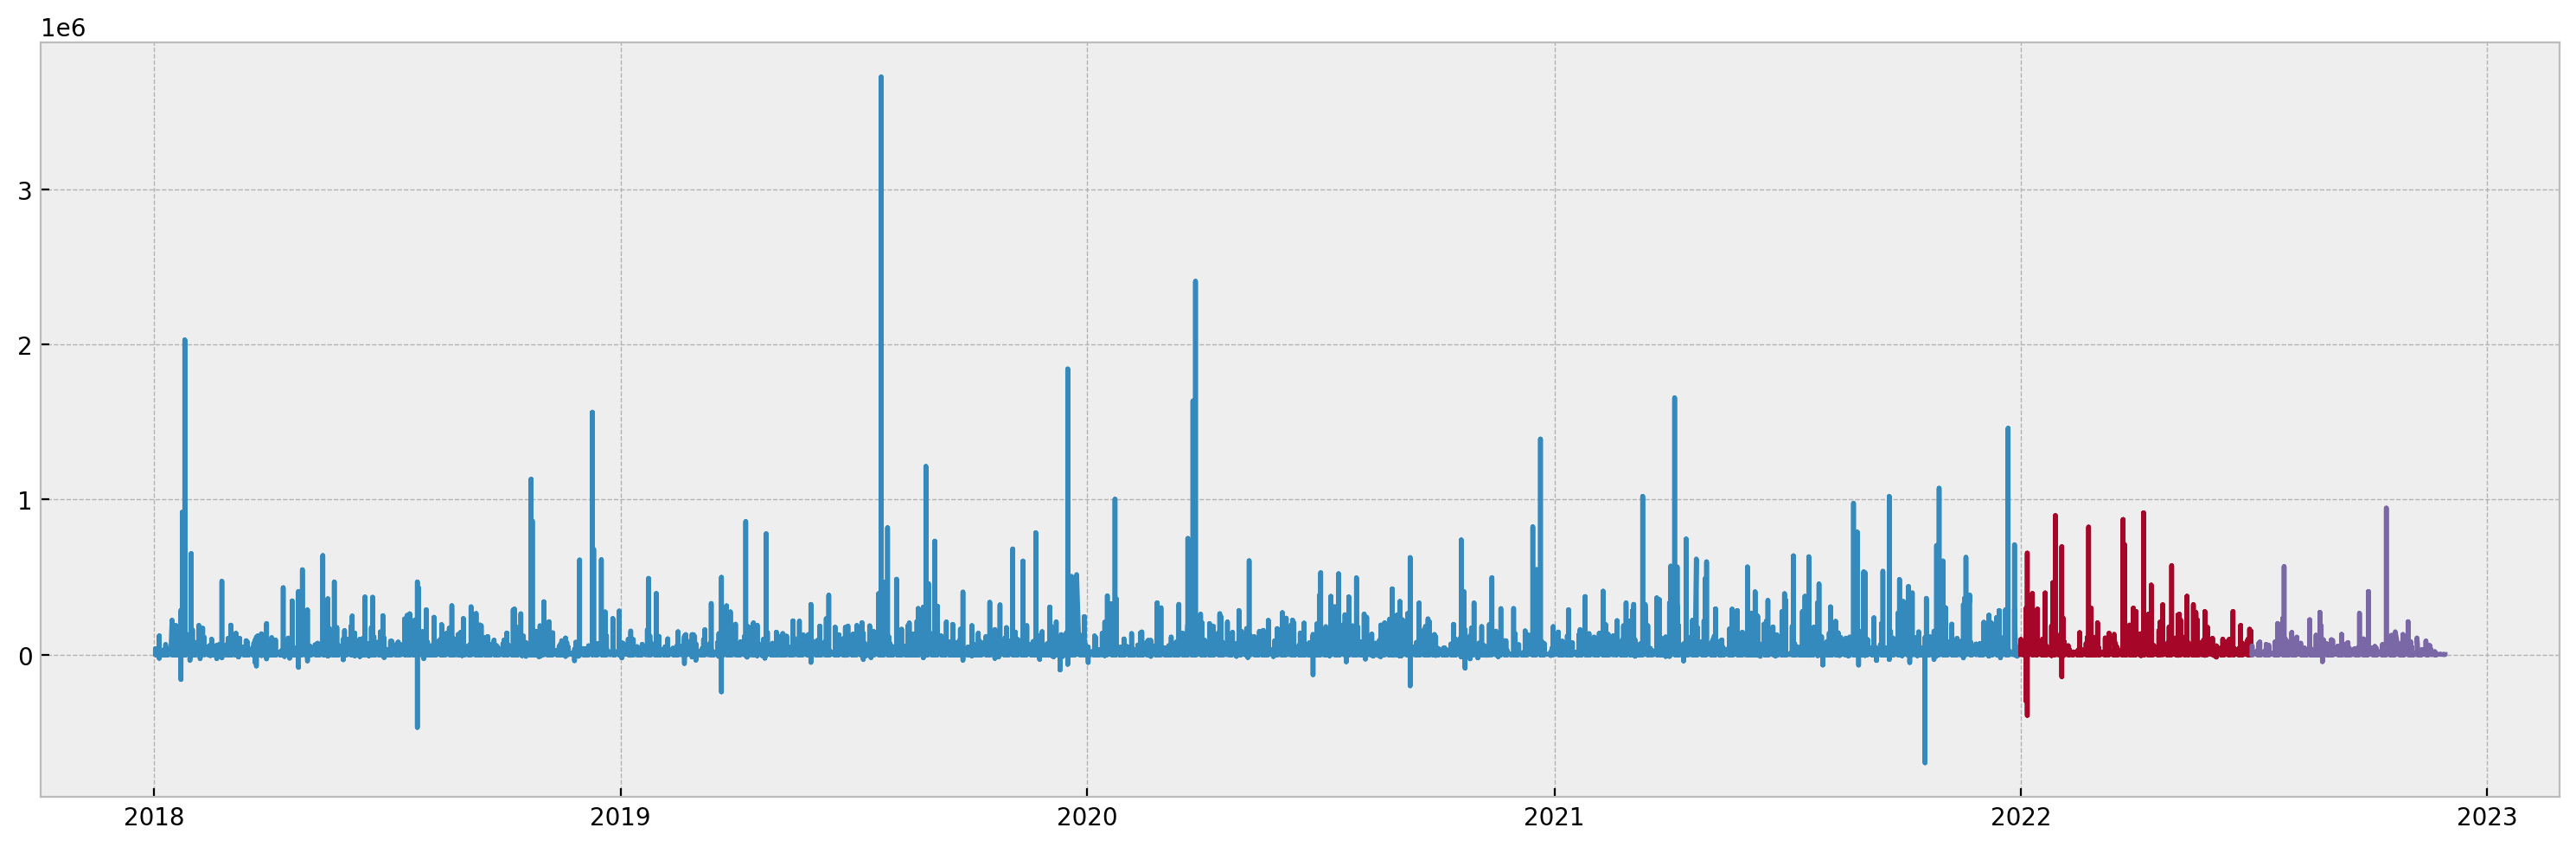

In [10]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(train.index, train['purchase_amount'])
plt.plot(validate.index, validate['purchase_amount'])
plt.plot(test.index, test['purchase_amount'])

### alternative plots

In [19]:
def clean_df(df):
    df = df.drop(columns = ['shipped_date', 'order_date_copy'])
    df['purchase_amount'] = df['purchase_amount'].astype('int64')
    df['customer_zip'] = df['customer_zip'].astype('int16')
    df['order_quantity'] = df['order_quantity'].astype('int16')
    df['unit_price'] = df['unit_price'].astype('float64')
    
    return df

In [20]:
df = clean_df(df)

In [ ]:
df_large_price = df[df['unit_price'] > 5]
df_small_price = df[df['unit_price'] <= 5]

In [ ]:
df_large_price.shape[0], df_small_price.shape[0], df_large_price.shape[0] + df_small_price.shape[0], df.shape[0]

(232629, 29257, 261886, 261886)

In [43]:
df = wr.get_clean_data(start2018=True)
df = clean_df(df)
n = 5
df_large_price = df[df['unit_price'] > n]
df_small_price = df[df['unit_price'] <= n]

lp_train, lp_test = wr.split_data(df_large_price, explore=True)
lp_validate = lp_test.loc[:'2022-06'].copy() 
lp_test = lp_test.loc['2022-07':]

sp_train, sp_test = wr.split_data(df_small_price, explore=True)
sp_validate = sp_test.loc[:'2022-06'].copy() 
sp_test = sp_test.loc['2022-07':]

/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:128: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week
/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.customer_type.replace({'Assistance Org':'Other'},inplace=True)


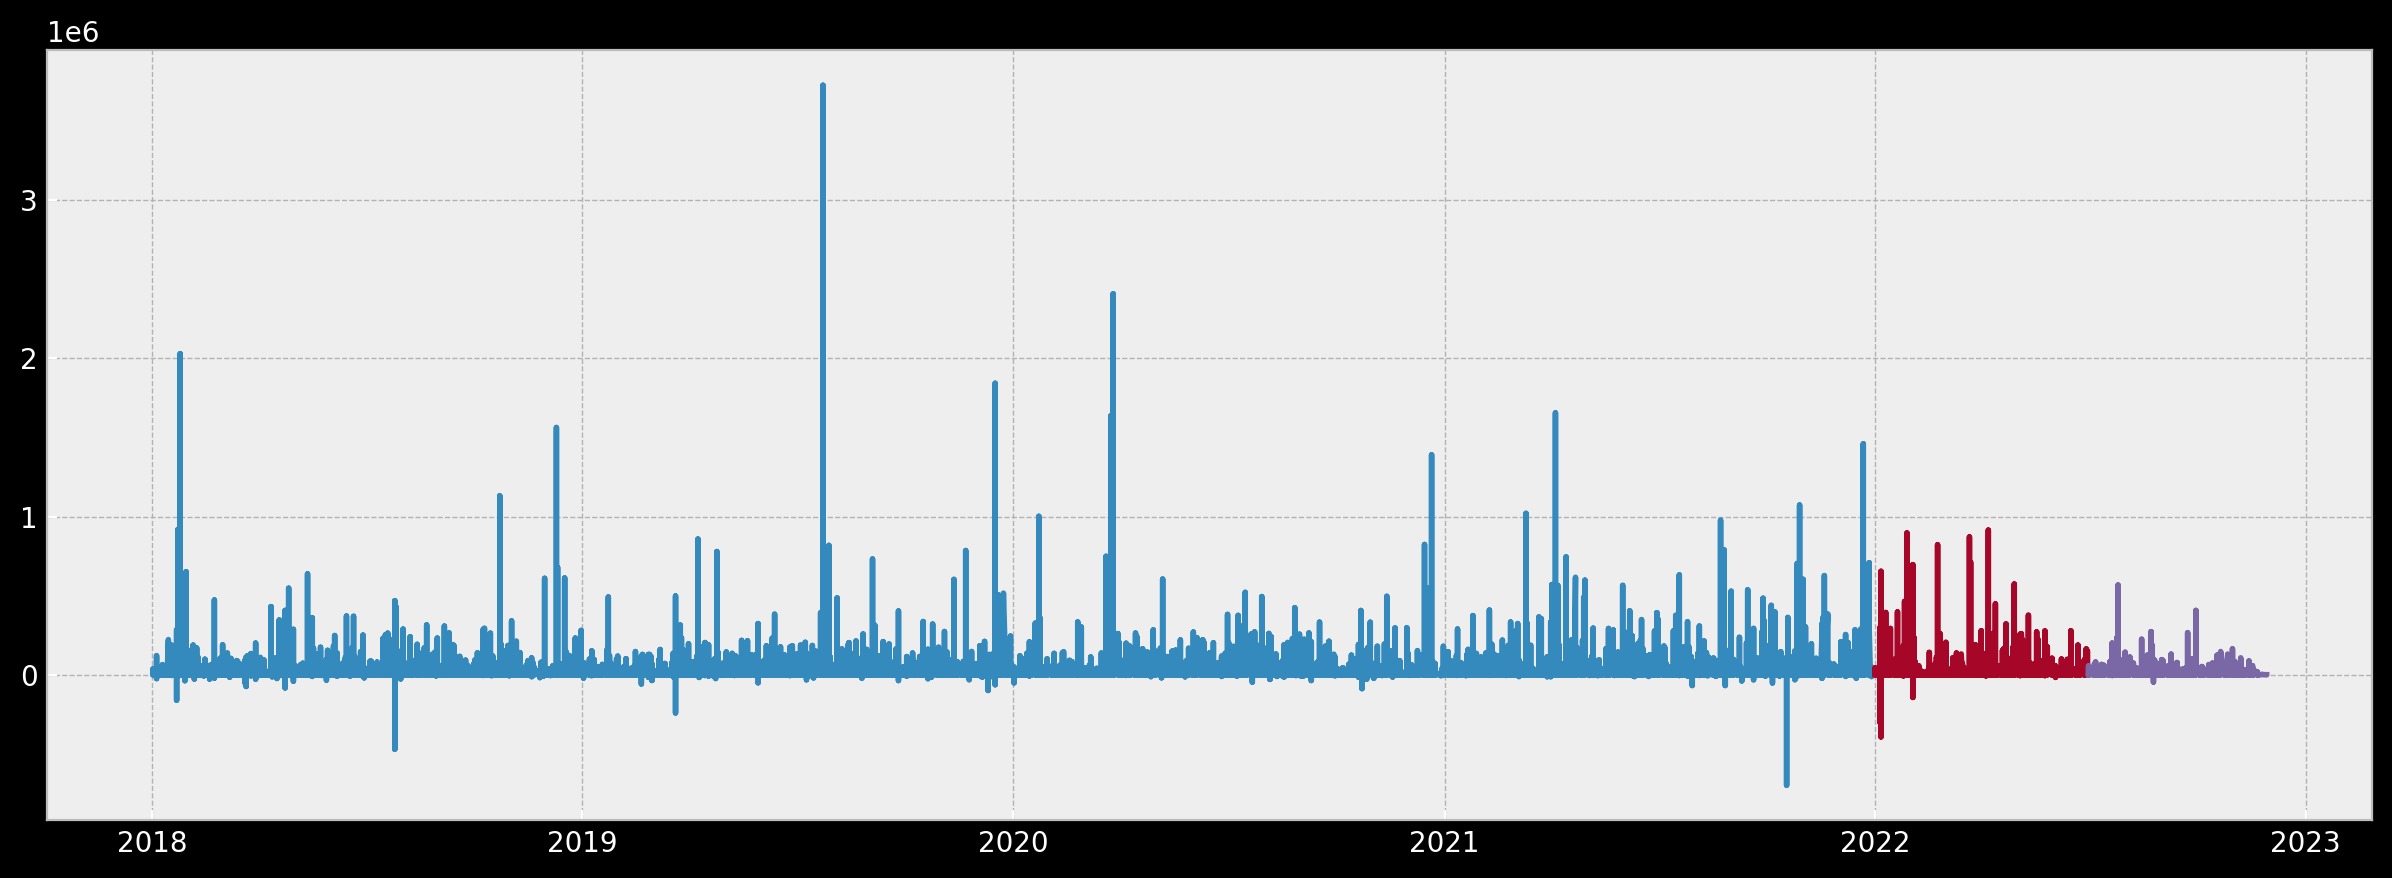

In [44]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

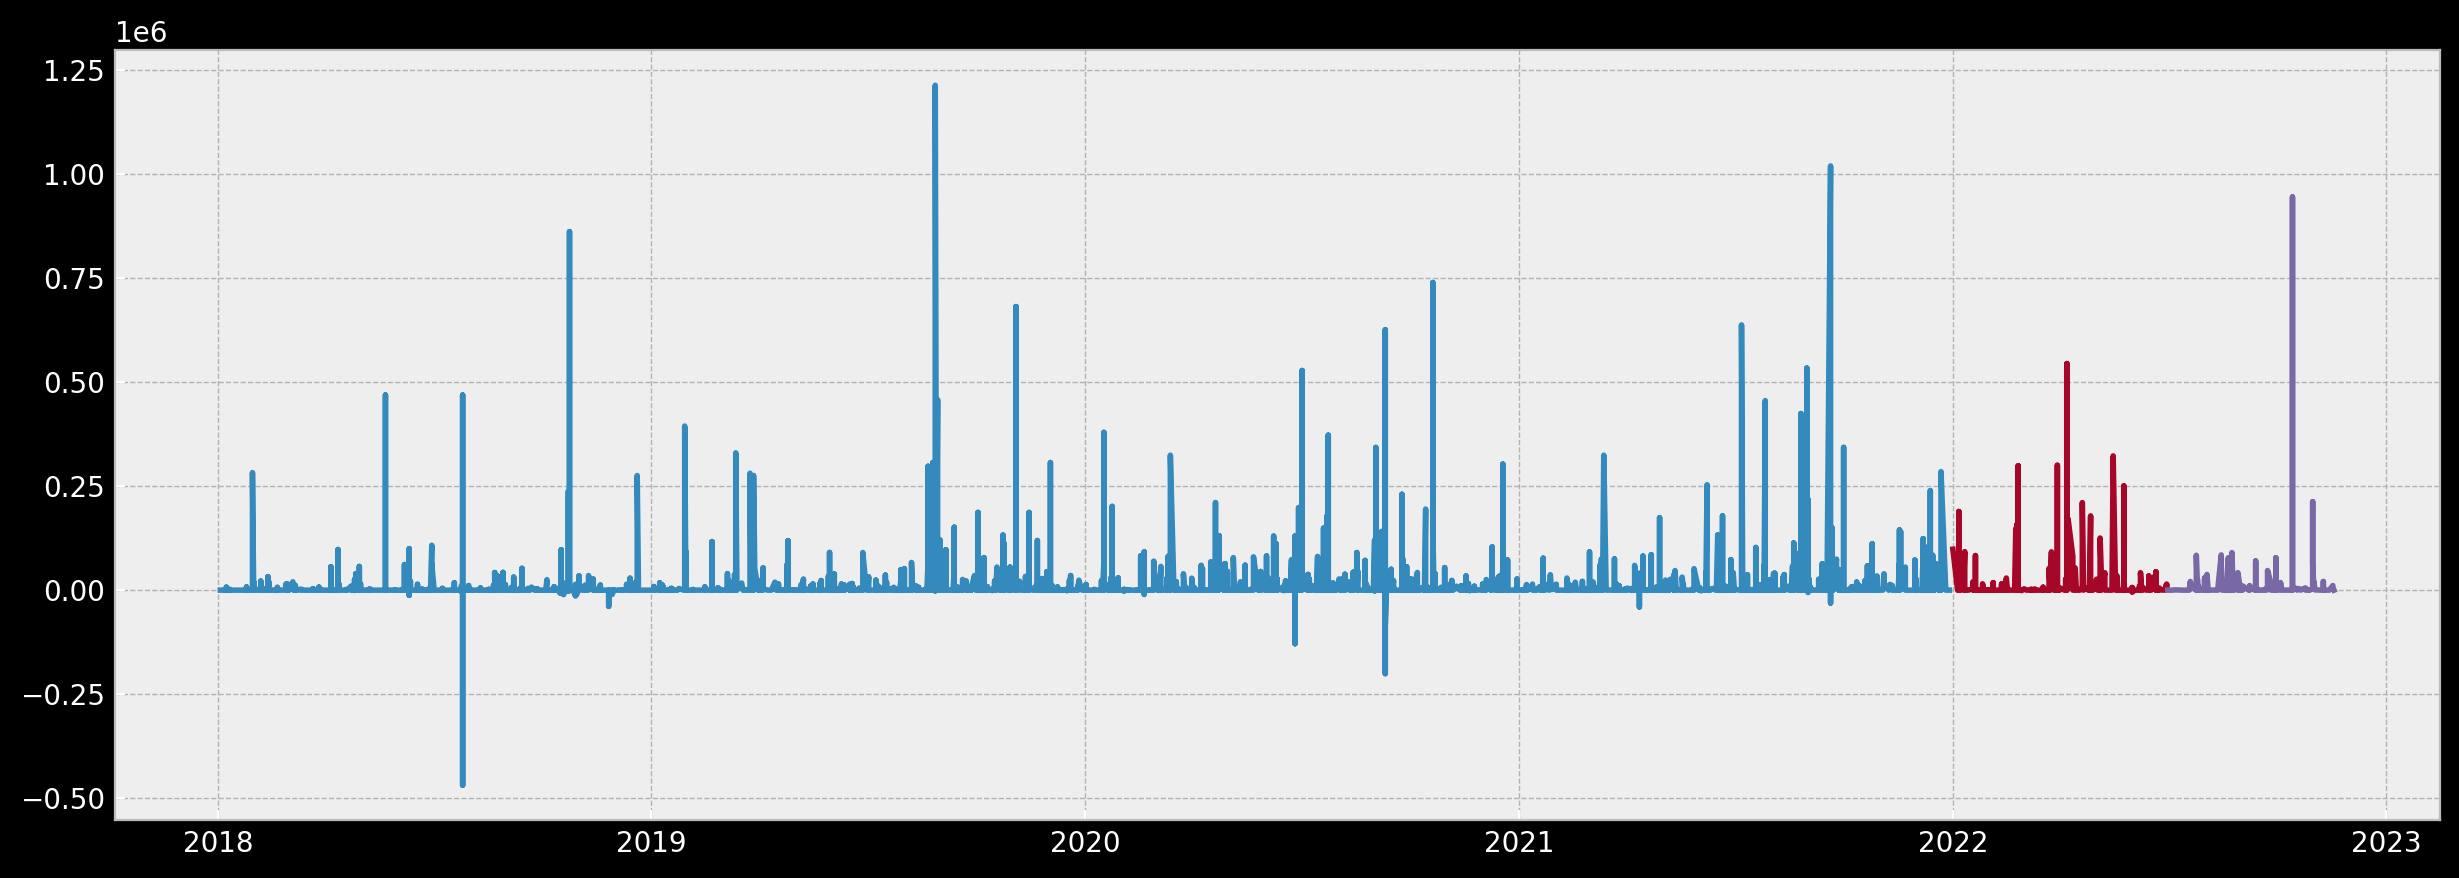

In [45]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])

## Small Train

-[return to TOC](#Table-of-Contents)

<AxesSubplot:xlabel='order_date'>

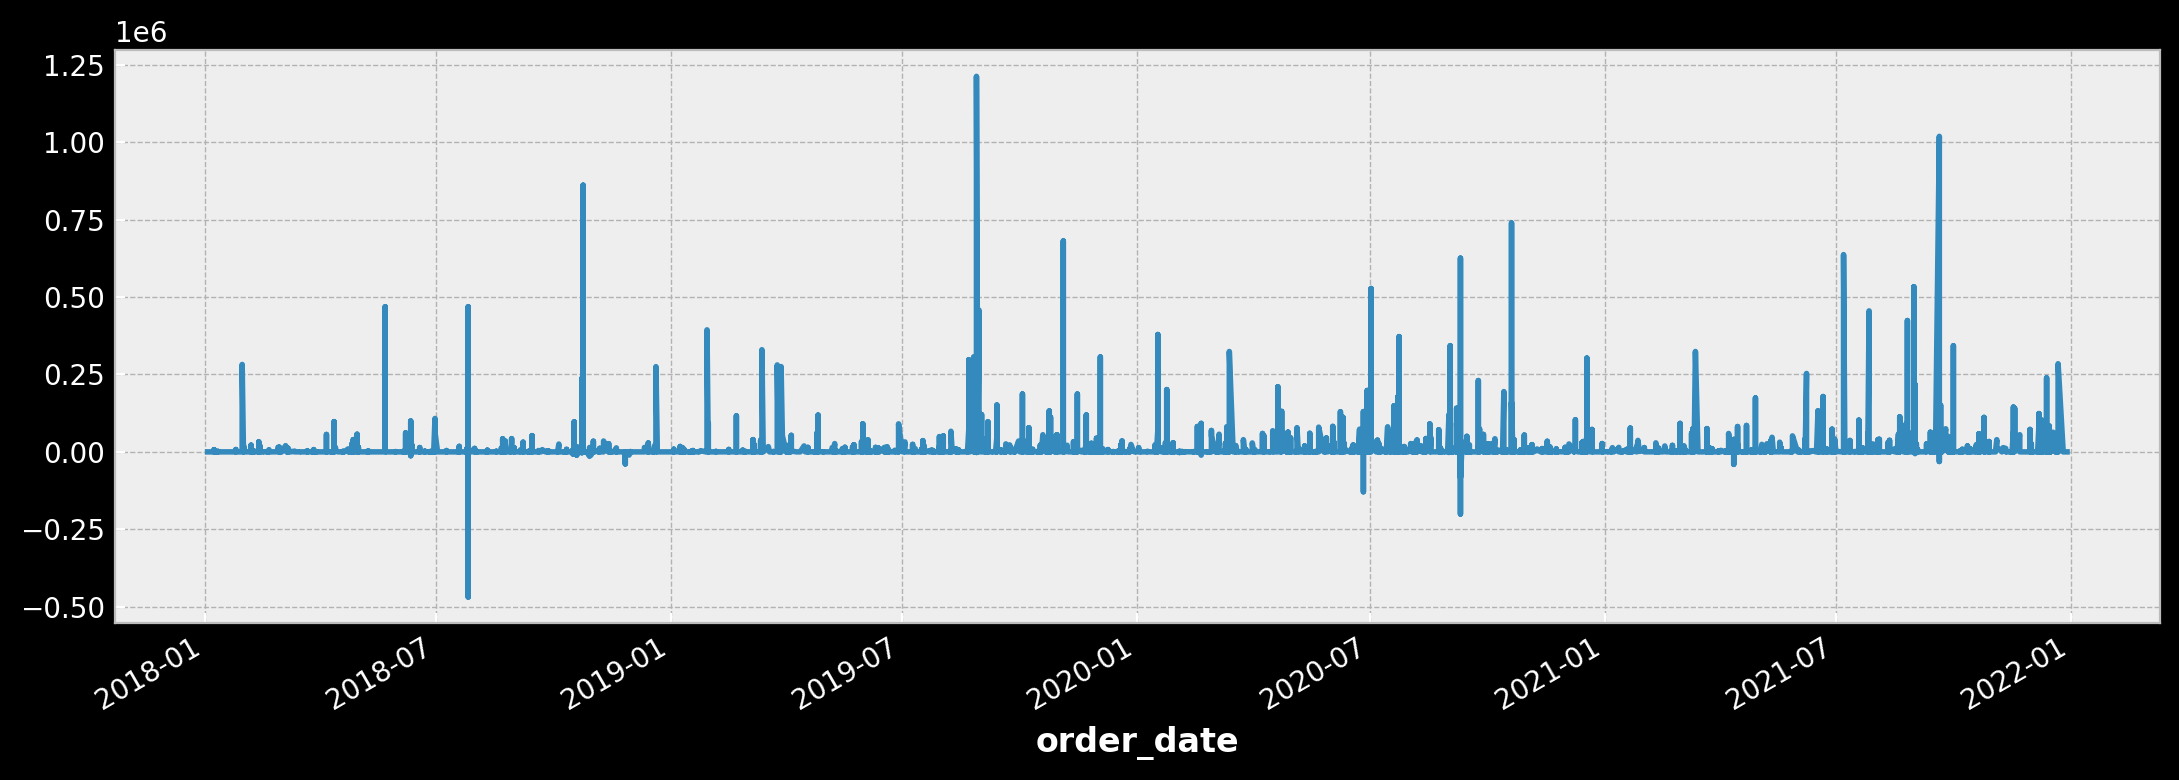

In [53]:
small_train = sp_train['purchase_amount'].copy()
small_train.plot()

In [54]:
small_baseline = small_train.mean()
small_baseline

1797.7566462920686

### Variables
- sp_train
- sp_validate
- sp_test

## Large Train

-[return to TOC](#Table-of-Contents)

<AxesSubplot:xlabel='order_date'>

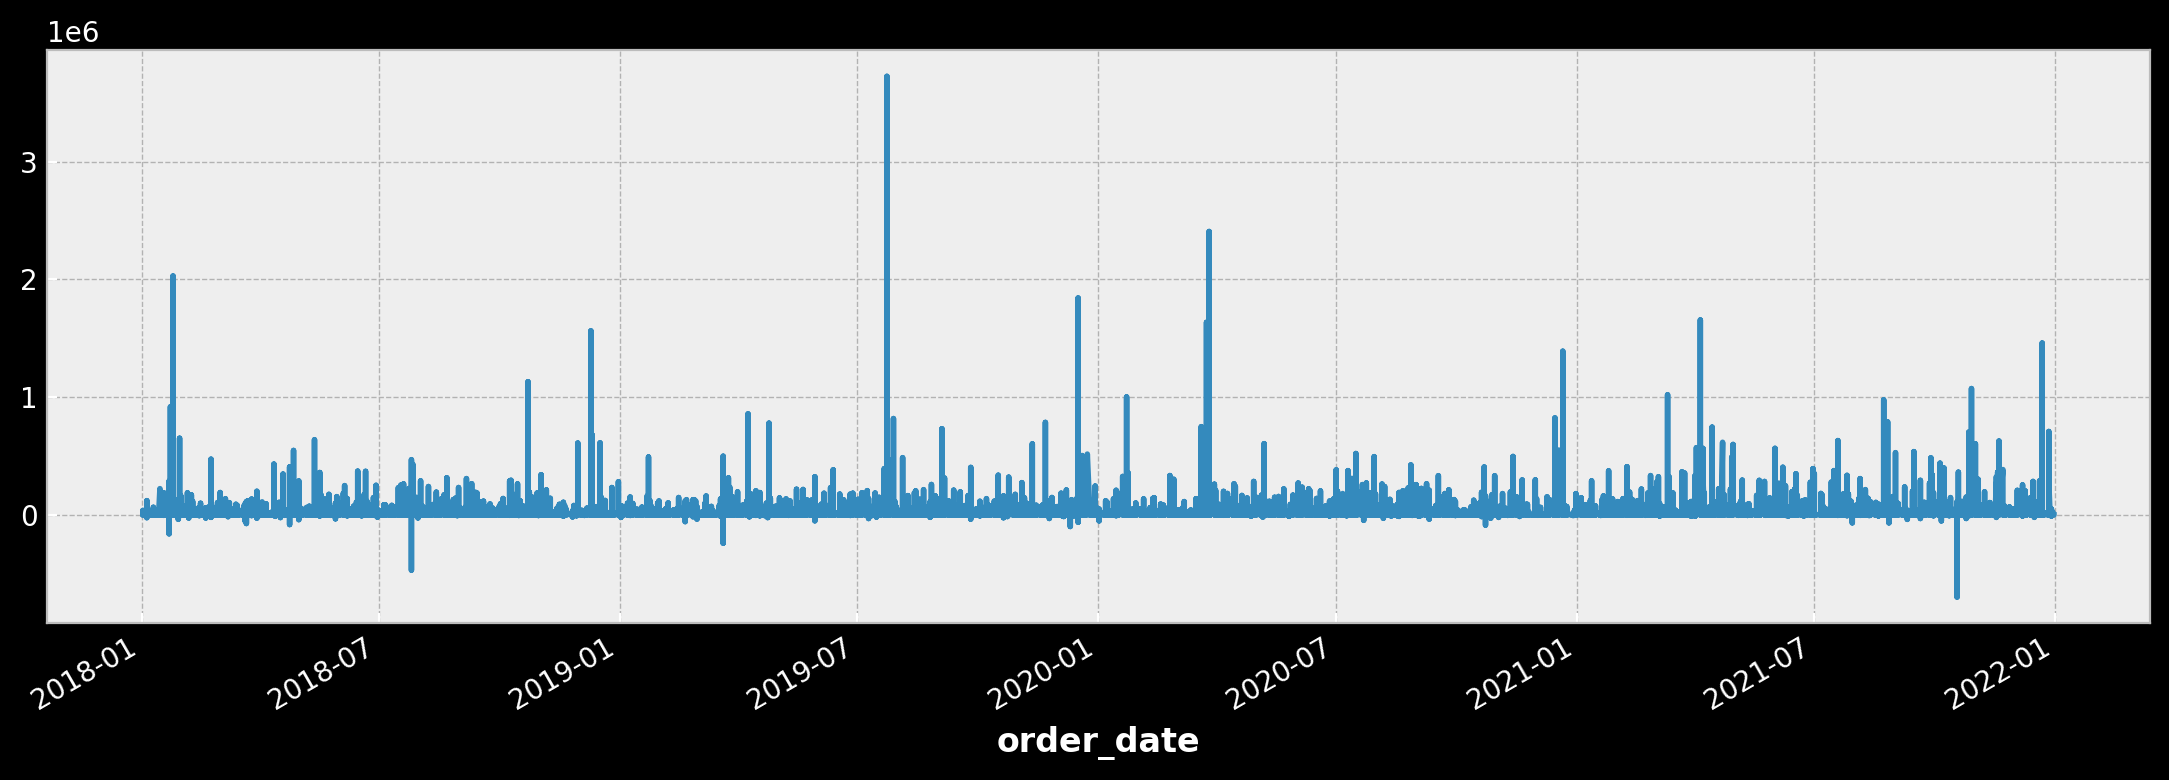

In [55]:
large_train = lp_train['purchase_amount'].copy()
large_train.plot()

In [56]:
large_baseline = large_train.mean()
large_baseline

4353.641042007612

## XGBoost Model standard dataset

-[return to TOC](#Table-of-Contents)

## XGBoost 

In [86]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

features = ['month', 'week', 'day_of_week', 'year','day_of_year']
target = 'purchase_amount'
x_train = train[features]
y_train = train[target]
x_validate = validate[features]
y_validate = validate[target]

In [87]:
xgboost_regular_model = xgb.XGBRegressor(n_estimators = 1000, 
                         early_stopping_rounds = 50,
                         learning_rate=0.01)
xgboost_regular_model.fit(x_train, y_train,
         eval_set = [(x_train, y_train), (x_validate, y_validate)],
         verbose = 10)
                         

[0]	validation_0-rmse:24440.07549	validation_1-rmse:28822.71383
[10]	validation_0-rmse:24360.91935	validation_1-rmse:28738.25694
[20]	validation_0-rmse:24294.89238	validation_1-rmse:28669.79208
[30]	validation_0-rmse:24239.68707	validation_1-rmse:28612.51180
[40]	validation_0-rmse:24192.92933	validation_1-rmse:28564.39487
[50]	validation_0-rmse:24153.75170	validation_1-rmse:28524.41218
[60]	validation_0-rmse:24121.07320	validation_1-rmse:28490.52209
[70]	validation_0-rmse:24093.28484	validation_1-rmse:28463.91321
[80]	validation_0-rmse:24070.07107	validation_1-rmse:28441.63222
[90]	validation_0-rmse:24050.27331	validation_1-rmse:28424.13923
[100]	validation_0-rmse:24033.25716	validation_1-rmse:28409.66610
[110]	validation_0-rmse:24016.09242	validation_1-rmse:28398.19810
[120]	validation_0-rmse:23998.36585	validation_1-rmse:28389.64829
[130]	validation_0-rmse:23982.62792	validation_1-rmse:28382.98242
[140]	validation_0-rmse:23969.02136	validation_1-rmse:28379.15454
[150]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### XGBoost Feature importance

In [54]:
xgboost_features = pd.DataFrame(data=model.feature_importances_,
                                 index=model.feature_names_in_,
                                 columns=['importance'])

In [51]:
xgboost_features.sort_values('importance')

,importance
quarter,0.00000
day_of_week,0.15439
week,0.15519
month,0.17037
year,0.20094
day_of_year,0.31911


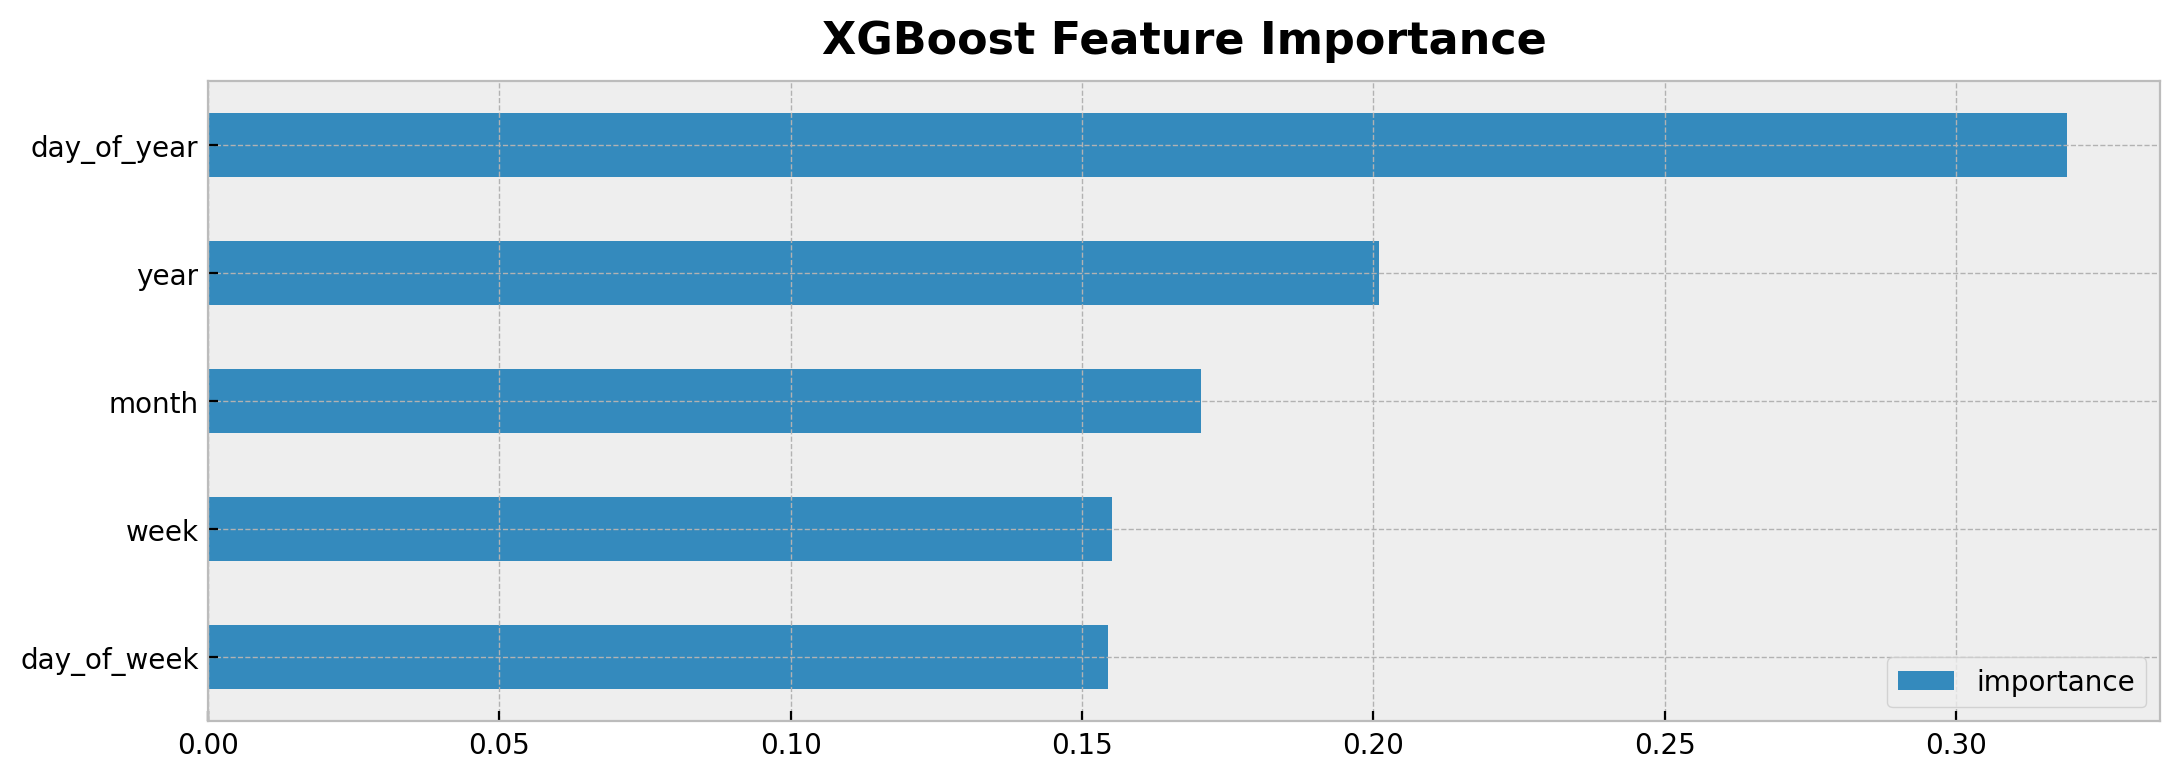

In [56]:
xgboost_features.sort_values('importance').plot(kind='barh', title = 'XGBoost Feature Importance')
plt.show()

## Validating XGBoost Model

In [75]:
xgboost_regular_model.predict(x_validate)

array([3644.9868, 3644.9868, 3644.9868, ..., 4658.1455, 4658.1455,
       4658.1455], dtype=float32)

In [ ]:
validate['predicted_purchases'] = xgboost_regular_model.predict(x_validate)
val_df = df.merge(validate[['predicted_purchases']], how='left', left_index=True, right_index=True)

In [78]:
validate.sort_values(by ='predicted_purchases', ascending = False).head()

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,...,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount,predicted_purchases
order_date,,,,,,,,,,,,,,,,,,,,,
2022-04-02,Lyford Consolidated Independent School District,K-12,Lyford,"Insight Public Sector, Inc.",Tempe,78569.00000,120.00000,18.41000,130196,2022-06-30,...,2022,2,April,Saturday,4,13,5,92,2209.20000,12972.61523
2022-03-11,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Netsync Network Solutions, Inc.",Houston,78586,2.00000,246.09000,8732200181,2022-04-04,...,2022,1,March,Friday,3,10,4,70,492.18000,9187.14551
2022-03-11,DeWitt County,Local Government,Cuero,"SHI Government Solutions, Inc.",Austin,77954,1.00000,142.71000,PO05683,2022-03-17,...,2022,1,March,Friday,3,10,4,70,142.71000,9187.14551
2022-03-11,Texas Department of State Health Services,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,78756,3783.57000,0.79000,HHSTX-2-283310,2022-03-16,...,2022,1,March,Friday,3,10,4,70,2989.02000,9187.14551
2022-03-11,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Netsync Network Solutions, Inc.",Houston,78586,6.00000,7097.30000,8732200181,2022-04-24,...,2022,1,March,Friday,3,10,4,70,42583.80000,9187.14551


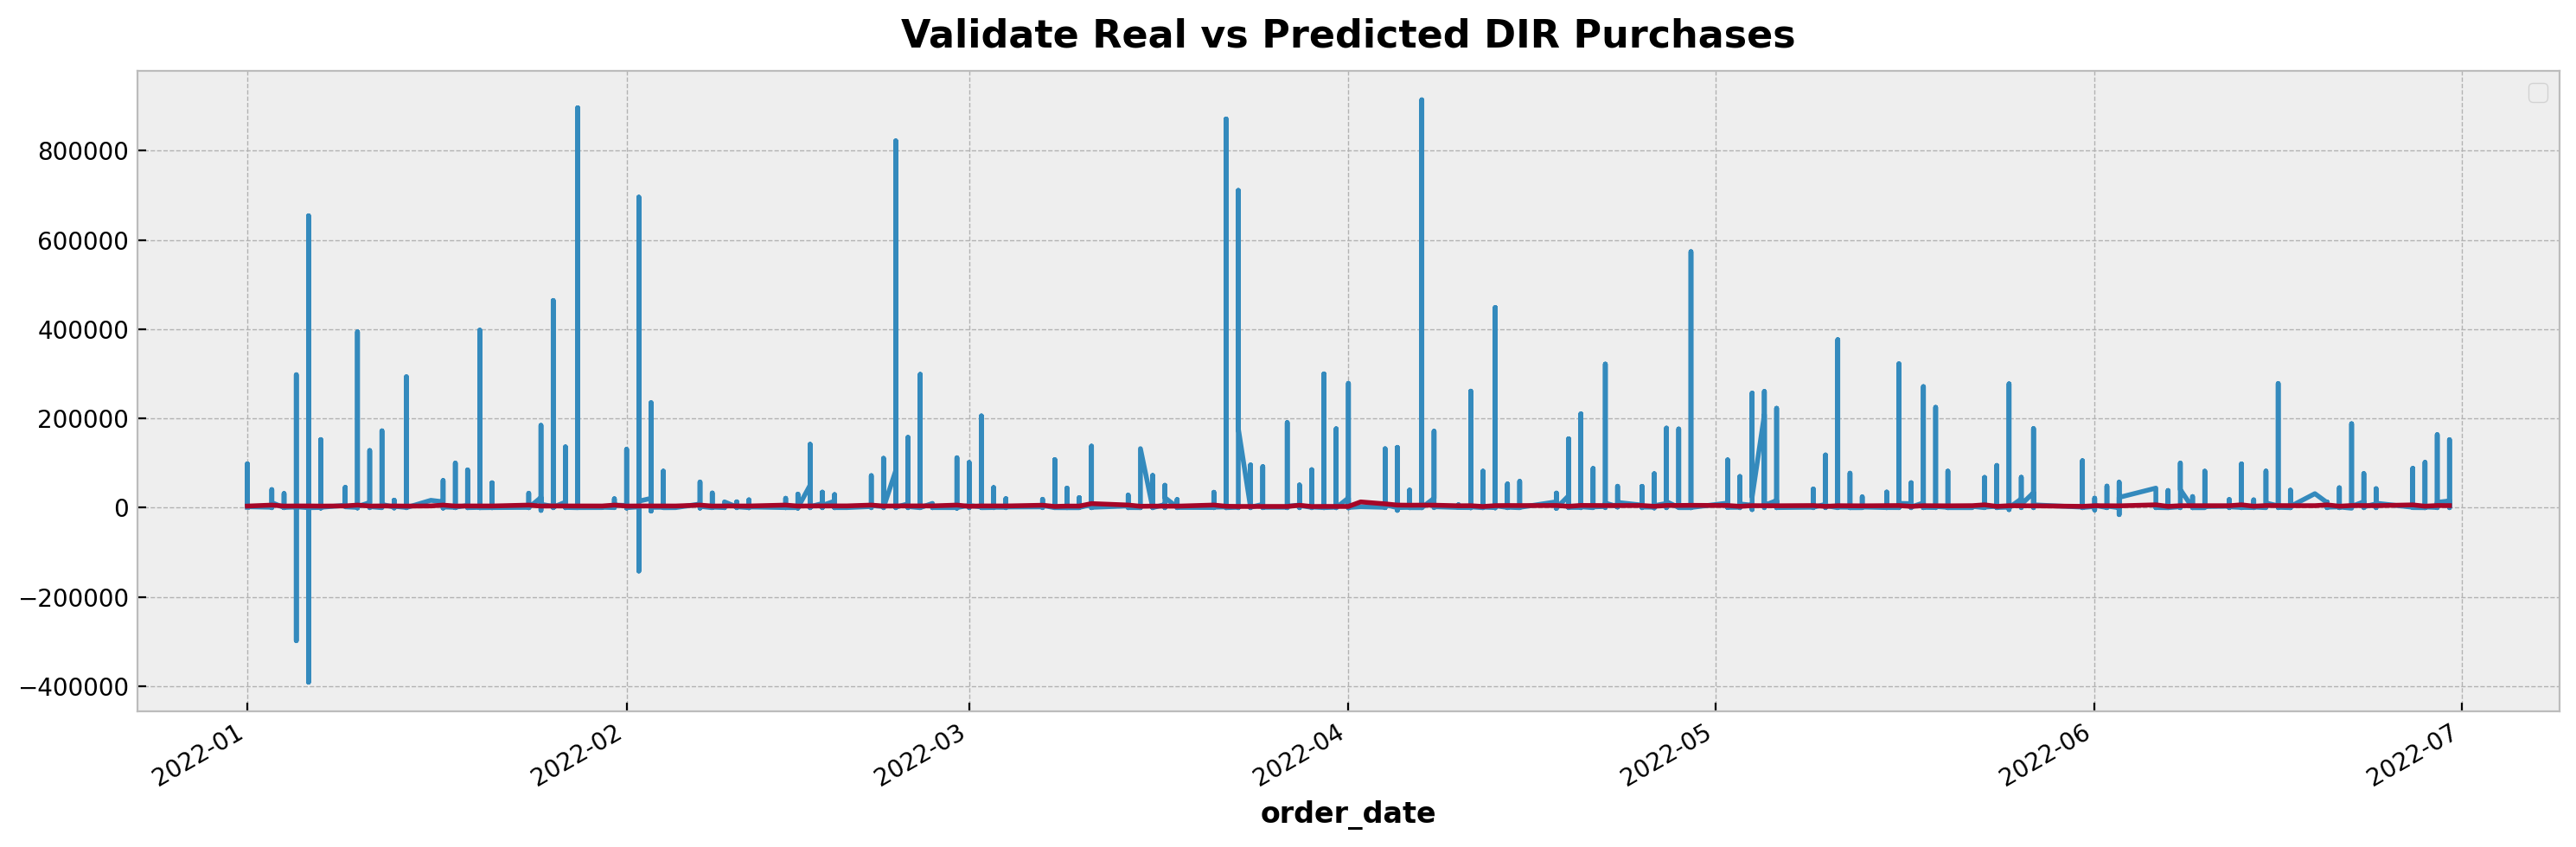

In [74]:
ax = validate['purchase_amount'].plot(figsize=(15,5))
validate['predicted_purchases'].plot(ax=ax)
ax.set_title('Validate Real vs Predicted DIR Purchases')
plt.legend('Real Purchases', 'Predicted Purchases')
plt.show()

## XGBoost Model summary dataset

-[return to TOC](#Table-of-Contents)

In [84]:
df = su.get_summary_df(wr.get_clean_data(start2018=True))
df = wr.add_date_features(df)

train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

features = ['month', 'week', 'day_of_week', 'year','day_of_year']
target = 'purchase_amount'
x_train = train[features]
y_train = train[target]
x_validate = validate[features]
y_validate = validate[target]

In [85]:
xgboost_summary_model = xgb.XGBRegressor(n_estimators = 1000, 
                         early_stopping_rounds = 50,
                         learning_rate=0.01)
xgboost_summary_model.fit(x_train, y_train,
         eval_set = [(x_train, y_train), (x_validate, y_validate)],
         verbose = 10)
                         

[0]	validation_0-rmse:129605.66336	validation_1-rmse:120782.60288
[10]	validation_0-rmse:128762.34833	validation_1-rmse:119911.48951
[20]	validation_0-rmse:128057.37237	validation_1-rmse:119208.15047
[30]	validation_0-rmse:127462.77339	validation_1-rmse:118625.50137
[40]	validation_0-rmse:126960.26755	validation_1-rmse:118171.79533
[50]	validation_0-rmse:126541.28030	validation_1-rmse:117791.59524
[60]	validation_0-rmse:126188.39961	validation_1-rmse:117469.94346
[70]	validation_0-rmse:125892.50329	validation_1-rmse:117212.05815
[80]	validation_0-rmse:125636.97296	validation_1-rmse:117024.26255
[90]	validation_0-rmse:125422.41844	validation_1-rmse:116874.01776
[100]	validation_0-rmse:125240.40653	validation_1-rmse:116752.98215
[110]	validation_0-rmse:125080.01431	validation_1-rmse:116659.62161
[120]	validation_0-rmse:124949.30837	validation_1-rmse:116591.39559
[130]	validation_0-rmse:124826.80715	validation_1-rmse:116530.63053
[140]	validation_0-rmse:124712.75733	validation_1-rmse:1164

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Model Evaluation

-[return to TOC](#Table-of-Contents)

## Setting up an evaluation holding dataframe

In [100]:
eval_df = pd.DataFrame(columns=['model_name', 'train_RMSE', 'train_R2', 'validate_RMSE', 'validateR2'])
X_train_ts = train.purchase_amount.copy().resample('D').sum()
baseline = X_train_ts.mean()



In [97]:
baseline_train_estimate = np.full((y_train.shape), baseline)
baseline_train_validate = np.full((y_validate.shape), baseline)

In [98]:
# evaluating models using R^2
baselineR2train         = r2_score(y_train, baseline_train_estimate)
baselineR2validate      = r2_score(y_validate, baseline_train_validate)
xgb_regular_R2_train    = r2_score(y_train, xgboost_regular_model.predict(x_train))
xgb_regular_R2_validate = r2_score(y_validate, xgboost_regular_model.predict(x_validate))
xgb_summary_R2_train    = r2_score(y_train, xgboost_summary_model.predict(x_train))
xgb_summary_R2_validate = r2_score(y_validate, xgboost_summary_model.predict(x_validate))

# evaluating models using RMSE
baselineRMSEtrain         = mean_squared_error(y_train, baseline_train_estimate, squared = False)
baselineRMSEvalidate      = mean_squared_error(y_validate, baseline_train_validate, squared = False)
xgb_regular_RMSE_train    = mean_squared_error(y_train, xgboost_regular_model.predict(x_train), squared = False)
xgb_regular_RMSE_validate = mean_squared_error(y_validate, xgboost_regular_model.predict(x_validate), squared = False)
xgb_summary_RMSE_train    = mean_squared_error(y_train, xgboost_summary_model.predict(x_train), squared = False)
xgb_summary_RMSE_validate = mean_squared_error(y_validate, xgboost_summary_model.predict(x_validate), squared = False)


In [104]:
eval_df = eval_df.append('baseline', baselineR2train, baselineR2validate, baselineRMSEtrain, baselineRMSEvalidate)
eval_df = eval_df.append('xgb_regular', xgb_regular_R2_train, xgb_regular_R2_validate, xgb_regular_RMSE_train, xgb_regular_RMSE_validate)
eval_df = eval_df.append('xgb_summary', xgb_summary_R2_train, xgb_summary_R2_validate, xgb_summary_RMSE_train, xgb_summary_RMSE_validate)


TypeError: append() takes from 2 to 5 positional arguments but 6 were given